This is the second pratice code for the application of Double Machine Learning (DML) to estimate the effect of 401(k) participation on retirement savings. 
The 401K data considered here is from the Survey of Income and Program Participation (SIPP) from the year 1991. We use the data taken from the application in Chernozhukov et al. (2018). This time we play around with different models and compare the results. 
401(k) plans are pension accounts sponsored by employers. A major challenge in assessing the impact of participating in 401(k) plans on accumulated savings arises from saver heterogeneity and the non-random nature of enrollment decisions. Individuals differ significantly in their preferences for saving, and it is reasonable to assume that those with stronger, unobserved preferences for saving are more inclined to participate in tax-advantaged retirement plans such as 401(k)s. Consequently, these individuals likely have higher accumulated assets regardless of participation. Failure to account for this saver heterogeneity and the endogenous nature of participation decisions leads to upward-biased estimates, overstating the actual savings effects attributable to 401(k) participation.

To address this bias, it can be argued that eligibility for enrolling in a 401(k) plan can be considered exogenous once certain observable factors, especially income, are controlled for. This argument rests on the premise that when 401(k) plans were initially introduced, employment decisions were generally driven by income and other job characteristics, rather than by the availability of a 401(k). Thus, after conditioning on income and similar observables, eligibility for a 401(k) is less likely to be correlated with unobserved preferences for saving.- source:https://docs.doubleml.org/dev/examples/py_double_ml_pension.html

We use net financial assets (net_tfa) as the outcome variable. The treatment variable is 401(k) participation. The covariates are age, income, education, marital status and other worker characteristics such as family size, dual-earner status, defined-benefit pension, IRA participation, and home ownership.

In [4]:
import numpy as np
import pandas as pd
import doubleml as dml
# Load the dataset
data = pd.read_stata('/Users/prachijhamb/Downloads/sipp1991.dta')
print(f"Data shape: {data.shape}")
print("Outcome (net_tfa) and treatment (p401) summary:")
print(data[['net_tfa','p401']].describe())

Data shape: (9915, 14)
Outcome (net_tfa) and treatment (p401) summary:
            net_tfa         p401
count  9.915000e+03  9915.000000
mean   1.805153e+04     0.261624
std    6.352259e+04     0.439541
min   -5.023020e+05     0.000000
25%   -5.000000e+02     0.000000
50%    1.499000e+03     0.000000
75%    1.652450e+04     1.000000
max    1.536798e+06     1.000000


The variable e401 indicates eligibility and p401 indicates participation in 401(k) plan.

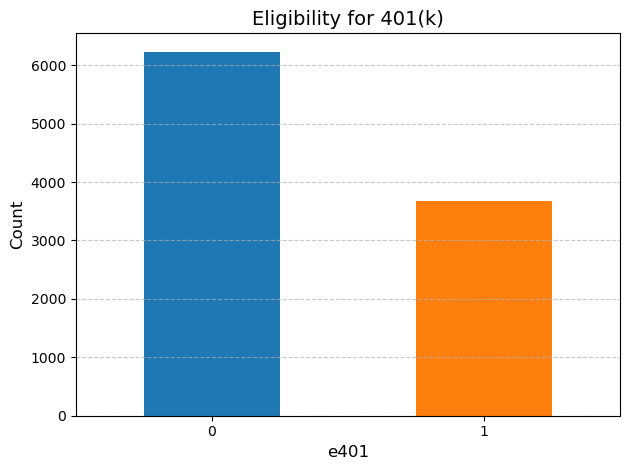

In [5]:
#Create a bar plot of the eligibility for 401(k) plans. The variable e401 has two values: 1 if the respondent is eligible for a 401(k) plan and 0 otherwise.
# Define colors explicitly
colors = ['#1f77b4', '#ff7f0e']

import matplotlib.pyplot as plt
# Set matplotlib attribute to plot the graph inline
%matplotlib inline
# Plotting
data['e401'].value_counts().plot(kind='bar', color=colors)
plt.title('Eligibility for 401(k)', fontsize=14)
plt.xlabel('e401', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

The density plots below show the comparison between these two groups. We notice that individuals eligible for a 401(k) (e401 = 1) generally have higher net total financial assets compared to individuals who are not eligible (e401 = 0). 

In [ ]:
import seaborn as sns
# Set up FacetGrid to create separate plots based on 'e401'
g = sns.FacetGrid(data, col='e401', hue='e401', palette='Set2', height=5, aspect=1.2, sharey=True)

# Add density plots within each facet
g.map(sns.kdeplot, 'net_tfa', fill=True, common_norm=False, alpha=0.5)

# Set x-axis limits to match your ggplot specification
g.set(xlim=(-20000, 150000))

# Add titles and axis labels
g.set_axis_labels('net_tfa', 'Density')
g.set_titles('e401 = {col_name}')

# Improve layout
plt.tight_layout()
plt.show()

#Estimate average potential outcomes
We compute the simple difference in means or the unconditional average predictive effect (APE) of 401(k) eligibility on accumulated assets. This measure would reflect the average treatment effect if eligibility for a 401(k) plan were randomly assigned across all individuals. 

In [6]:
# Filter data where e401 == 1 and e401 == 0
e1 = data[data['e401'] == 1]
e0 = data[data['e401'] == 0]

# Calculate the simple difference in means for net_tfa
mean_diff_e = round(np.mean(e1['net_tfa']) - np.mean(e0['net_tfa']), 0)
print(mean_diff_e)

# Filter data based on p401
p1 = data[data['p401'] == 1]
p0 = data[data['p401'] == 0]

# Compute and round the difference in means
mean_diff_p = round(np.mean(p1['net_tfa']) - np.mean(p0['net_tfa']), 0)
print(mean_diff_p )


19559.0
27372.0


The unconditional APE of e401 is about 19559: individuals eligible for a 401(k) have about $19559 more in net total financial assets compared to those who are not eligible.
Among the 3682 individuals that are eligible,  2594 decided to participate in the program. The unconditional APE of p401 is about  27372: individuals who participate in a 401(k) have about $27372 more in net total financial assets compared to those who do not participate.
But, these estimates are biased since they do not account for the non-random nature of 401(k) participation decisions. 

In [7]:
# Define the features and outcome variables
control = ['age', 'inc', 'educ', 'fsize', 'marr', 'twoearn', 'db', 'pira', 'hown']
outcome = 'net_tfa'
treatment = 'p401'

# Initialize basic DoubleMLData object
data_dml_base = dml.DoubleMLData(data, 
                                 y_col= outcome,
                                 d_cols= treatment,
                                 x_cols=control)

print(data_dml_base)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: net_tfa
Treatment variable(s): ['p401']
Covariates: ['age', 'inc', 'educ', 'fsize', 'marr', 'twoearn', 'db', 'pira', 'hown']
Instrument variable(s): None
No. Observations: 9915

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9915 entries, 0 to 9914
Columns: 14 entries, nifa to hown
dtypes: float32(4), int8(10)
memory usage: 251.9 KB



In [8]:
from sklearn.preprocessing import PolynomialFeatures
## Step 4: Construct Polynomial Features for Flexible Model
# Start with indicator features
features = data[['marr', 'twoearn', 'db', 'pira', 'hown']].copy()

# Dictionary specifying polynomial degrees for selected variables
poly_dict = {'age': 2,
             'inc': 2,
             'educ': 2,
             'fsize': 2}

# Create polynomial features
for key, degree in poly_dict.items():
    poly = PolynomialFeatures(degree, include_bias=False)
    data_poly = poly.fit_transform(data[[key]])
    poly_feature_names = poly.get_feature_names_out([key])
    data_poly_df = pd.DataFrame(data_poly, columns=poly_feature_names, index=data.index)

    # Concatenate polynomial features
    features = pd.concat([features, data_poly_df], axis=1)

# Combine with outcome and treatment
model_data = pd.concat([data[['net_tfa', 'e401']], features], axis=1)
model_data
# Initialize the flexible DoubleMLData object
data_dml_flex = dml.DoubleMLData(model_data,
                                 y_col='net_tfa',
                                 d_cols='e401')

print(data_dml_flex)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: net_tfa
Treatment variable(s): ['e401']
Covariates: ['marr', 'twoearn', 'db', 'pira', 'hown', 'age', 'age^2', 'inc', 'inc^2', 'educ', 'educ^2', 'fsize', 'fsize^2']
Instrument variable(s): None
No. Observations: 9915

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9915 entries, 0 to 9914
Columns: 15 entries, net_tfa to fsize^2
dtypes: float32(3), float64(6), int8(6)
memory usage: 639.2 KB



Partially Linear Regression (PLR) model estimation using Lasso regression in Python with the DoubleML library. 

In [9]:
from sklearn.linear_model import LassoCV, LogisticRegressionCV
# Set random seed for reproducibility
np.random.seed(123)
## Define Lasso Learners for DoubleML
# Lasso for outcome (regression)
lasso_g = LassoCV(cv=5, random_state=123)

# Lasso for treatment (classification)
lasso_m = LogisticRegressionCV(cv=5, penalty='l1', solver='saga', max_iter=10000, random_state=123)


##Initialize and Fit the PLR Model
#we use double machine learning with 3-fold cross-fitting.
dml_plr = dml.DoubleMLPLR(data_dml_base,
                          ml_l=lasso_g,
                          ml_m=lasso_m,
                          n_folds=3)

# Fit the model and store predictions
dml_plr.fit(store_predictions=True)
print(dml_plr.summary)

              coef      std err        t         P>|t|        2.5 %  \
p401  10587.105961  1359.856171  7.78546  6.945996e-15  7921.836841   

           97.5 %  
p401  13252.37508  


In [10]:
# Estimate the ATE in the flexible model with lasso
#we use double machine learning with 3-fold cross-fitting.
np.random.seed(123)
dml_plr_lasso = dml.DoubleMLPLR(data_dml_flex,
                                ml_l = lasso_g,
                                ml_m = lasso_m,
                                n_folds = 3)

dml_plr_lasso.fit(store_predictions=True)
lasso_summary = dml_plr_lasso.summary
print(lasso_summary)

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


             coef      std err         t         P>|t|        2.5 %  \
e401  6392.151692  1171.982515  5.454136  4.921161e-08  4095.108172   

           97.5 %  
e401  8689.195212  


Then, we repeat this procedure for various machine learning methods.# Random Forest. We can compare the accuracy of this model to the model that has been estimated with lasso.

In [11]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
randomForest = RandomForestRegressor(
    n_estimators=500, max_depth=7, max_features=3, min_samples_leaf=3)
randomForest_class = RandomForestClassifier(
    n_estimators=500, max_depth=5, max_features=4, min_samples_leaf=7)

np.random.seed(123)
dml_plr_forest = dml.DoubleMLPLR(data_dml_base,
                                 ml_l = randomForest,
                                 ml_m = randomForest_class,
                                 n_folds = 3)
dml_plr_forest.fit(store_predictions=True)
forest_summary = dml_plr_forest.summary

print(forest_summary)

              coef     std err        t         P>|t|        2.5 %  \
p401  13726.869517  1514.46672  9.06383  1.259482e-19  10758.56929   

            97.5 %  
p401  16695.169743  


In [12]:
# Trees
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
trees = DecisionTreeRegressor(
    max_depth=30, ccp_alpha=0.0047, min_samples_split=203, min_samples_leaf=67)
trees_class = DecisionTreeClassifier(
    max_depth=30, ccp_alpha=0.0042, min_samples_split=104, min_samples_leaf=34)

np.random.seed(123)
dml_plr_tree = dml.DoubleMLPLR(data_dml_base,
                               ml_l = trees,
                               ml_m = trees_class,
                               n_folds = 3)
dml_plr_tree.fit(store_predictions=True)
tree_summary = dml_plr_tree.summary

print(tree_summary)

              coef      std err         t         P>|t|        2.5 %  \
p401  12638.769091  1557.825209  8.113085  4.935033e-16  9585.487788   

            97.5 %  
p401  15692.050395  


                coef         2.5 %        97.5 %
lasso    6392.151692   4095.108172   8689.195212
forest  13726.869517  10758.569290  16695.169743
tree    12638.769091   9585.487788  15692.050395


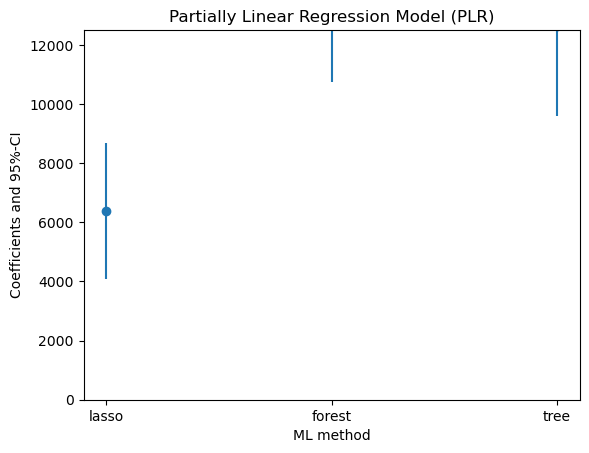

In [13]:
plr_summary = pd.concat((lasso_summary, forest_summary, tree_summary))
plr_summary.index = ['lasso', 'forest', 'tree']
print(plr_summary[['coef', '2.5 %', '97.5 %']])
errors = np.full((2, plr_summary.shape[0]), np.nan)
errors[0, :] = plr_summary['coef'] - plr_summary['2.5 %']
errors[1, :] = plr_summary['97.5 %'] - plr_summary['coef']
plt.errorbar(plr_summary.index, plr_summary.coef, fmt='o', yerr=errors)
plt.ylim([0, 12500])

plt.title('Partially Linear Regression Model (PLR)')
plt.xlabel('ML method')
_ =  plt.ylabel('Coefficients and 95%-CI')

In [14]:
#Instrumental Variable (IV) Estimation Using DoubleML
#Using eligibility for 401(k) as an instrument for participation in a 401(k) plan.

# Initialize DoubleMLData with an instrument

# Initialize DoubleMLData with an instrument

# Basic model
data_dml_base_iv = dml.DoubleMLData(data,
                                    y_col='net_tfa',
                                    d_cols='p401',
                                    z_cols='e401',
                                    x_cols= control)

print(data_dml_base_iv)


================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: net_tfa
Treatment variable(s): ['p401']
Covariates: ['age', 'inc', 'educ', 'fsize', 'marr', 'twoearn', 'db', 'pira', 'hown']
Instrument variable(s): ['e401']
No. Observations: 9915

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9915 entries, 0 to 9914
Columns: 14 entries, nifa to hown
dtypes: float32(4), int8(10)
memory usage: 251.9 KB



In [16]:
# Flexible model
model_data = pd.concat((data.copy()[['net_tfa', 'e401', 'p401']], features.copy()),
                        axis=1, sort=False)

data_dml_iv_flex = dml.DoubleMLData(model_data,
                                    y_col='net_tfa',
                                    d_cols='p401',
                                    z_cols='e401')

print(data_dml_iv_flex)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: net_tfa
Treatment variable(s): ['p401']
Covariates: ['marr', 'twoearn', 'db', 'pira', 'hown', 'age', 'age^2', 'inc', 'inc^2', 'educ', 'educ^2', 'fsize', 'fsize^2']
Instrument variable(s): ['e401']
No. Observations: 9915

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9915 entries, 0 to 9914
Columns: 16 entries, net_tfa to fsize^2
dtypes: float32(3), float64(6), int8(7)
memory usage: 648.9 KB



In [17]:
# Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
lasso = make_pipeline(StandardScaler(), LassoCV(cv=5, max_iter=20000))

# Initialize DoubleMLIRM model
np.random.seed(123)
dml_iivm_lasso = dml.DoubleMLIIVM(data_dml_iv_flex,
                                  ml_g = lasso,
                                  ml_m = lasso_m,
                                  ml_r = lasso_m,
                                  subgroups = {'always_takers': False,
                                             'never_takers': True},
                                  trimming_threshold = 0.01,
                                  n_folds = 3)
dml_iivm_lasso.fit(store_predictions=True)
lasso_summary = dml_iivm_lasso.summary

print(lasso_summary)

              coef      std err         t         P>|t|        2.5 %  \
p401  11607.325142  1816.740679  6.389093  1.668726e-10  8046.578843   

            97.5 %  
p401  15168.071441  
